In [3]:
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import shutil
import os
import sys
import copy
import pickle

sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *
from ZoneBudget_ludo import *

flopy is installed in c:\users\ludovic\anaconda3\envs\hydro\lib\site-packages\flopy


In [4]:
def north(ax,zoom=0.01,x0=664525+5e3,y0=6152875+5e3):
    
    """
    Plot a north image for maps
    """
    
    from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    arr_lena = mpimg.imread("../../images/north.png") # get image
    imagebox = OffsetImage(arr_lena,zoom=zoom) # create an image box
    ab = AnnotationBbox(imagebox, (x0,y0),frameon=False) # create the annotation box
    ax.add_artist(ab) # add the image

In [5]:
ref_dr = "200models_ref"
pred1_dr = "200models_s1"
pred2_dr = "200models_s2"
pred3_dr = "200models_s3"
workspace = "workspace"
m_n = "pest_3D_R"

sim = fp.mf6.MFSimulation.load(m_n,sim_ws=workspace,verbosity_level=0)
m = sim.get_model()
grid = m.modelgrid

In [6]:
nlay = m.dis.nlay.array
nrow = m.dis.nrow.array
ncol = m.dis.ncol.array
idomain = m.dis.idomain.array
botm = m.dis.botm.array
top = m.dis.top.array

In [7]:
imodel = 0
ws_load = ref_dr
h = get_heads(m_n+"_{}".format(imodel),ws_load)
b = get_cbc(m_n+"_{}".format(imodel),ws_load)

In [8]:
def get_allheads(directory,nmodels=150):
    
    HEADS = np.ones([nmodels,5,182,183])
    for imodel in range(nmodels):
        HEADS[imodel] = get_heads(m_n+"_{}".format(imodel),directory)
    HEADS[HEADS>1000] = np.nan
    
    return HEADS

In [9]:
def process_heads(heads,sigma=2):
    
    mu_heads = np.mean(heads,axis=0)
    med_heads = np.median(heads,axis=0)
    s_heads = np.std(heads,axis=0,ddof=1)
    ecart = sigma*(s_heads)
    
    return mu_heads,med_heads,s_heads,ecart

In [10]:
from Zone_Budget_mf6 import Zb
def get_allbudgets(directory,nmodels=150):
    
    lst = []
    
    a = np.array([1,2,4,4,6]) # Quat, eponte + PC, PMS
    a = a[np.newaxis,np.newaxis,:]
    zones = np.ones([nlay,nrow,ncol])*a.T
    #zones[idomain==0]=0
    #zones[0][idomain[0]==1]=0 # Quat marin
    zones[1][idomain[0]==1]=3 # Quat marin
    zones[3][idomain[0]==1]=5 # Pc marin

    dic_zones = {1:"interfQ",
                2 : "Q",
                3 : "Q marin",
                4 : "PC",
                5 : "PC marin",
                6 : "PMS"} # dic to attribute zone names !

    
    for imodel in range(nmodels):
        
        model_name = m_n+"_{}".format(imodel)
        cbc = get_cbc(m_n+"_{}".format(imodel),directory)
        zb = Zb(zones,m_n,workspace,cbc=cbc,dic_zones=dic_zones,m_n=1)
        DF_Budg = zb.get_Budget() # get DF budget
        lst.append(DF_Budg)
    
    return lst

In [11]:
def get_flux_Q_Pc(directory,nmodels=150):
    
    Q_Pc_flux = np.ones([nmodels,nrow,ncol])
    
    
    
    a = np.array([1,2,4,4,6]) # Quat, eponte + PC, PMS
    a = a[np.newaxis,np.newaxis,:]
    zones = np.ones([nlay,nrow,ncol])*a.T
    #zones[idomain==0]=0
    #zones[0][idomain[0]==1]=0 # Quat marin
    zones[1][idomain[0]==1]=3 # Quat marin
    zones[3][idomain[0]==1]=5 # Pc marin

    dic_zones = {1:"interfQ",
                2 : "Q",
                3 : "Q marin",
                4 : "PC",
                5 : "PC marin",
                6 : "PMS"} # dic to attribute zone names !


    for imodel in range(nmodels):
        model_name = m_n+"_{}".format(imodel)
        cbc = get_cbc(m_n+"_{}".format(imodel),directory)
        zb = Zb(zones,m_n,workspace,cbc=cbc,dic_zones=dic_zones,m_n=1)
    
        arr = np.nansum(zb.Z2Z_3D(2,4),axis=0)
        arr[idomain[1]!=1] = np.nan
    
        Q_Pc_flux[imodel] = arr
    
    return Q_Pc_flux

In [12]:
def get_flux_rivers(directory,nmodels=150):
    
    Q_riv = np.zeros([nmodels,nrow,ncol])    
    
    a = np.array([1,2,4,4,6]) # Quat, eponte + PC, PMS
    a = a[np.newaxis,np.newaxis,:]
    zones = np.ones([nlay,nrow,ncol])*a.T
    #zones[idomain==0]=0
    #zones[0][idomain[0]==1]=0 # Quat marin
    zones[1][idomain[0]==1]=3 # Quat marin
    zones[3][idomain[0]==1]=5 # Pc marin

    dic_zones = {1:"interfQ",
                2 : "Q",
                3 : "Q marin",
                4 : "PC",
                5 : "PC marin",
                6 : "PMS"} # dic to attribute zone names !

    for imodel in range(nmodels):
        model_name = m_n+"_{}".format(imodel)
        cbc = get_cbc(m_n+"_{}".format(imodel),directory)
        zb = Zb(zones,m_n,workspace,cbc=cbc,dic_zones=dic_zones,m_n=1)
    
        riv = ["AGLY","BOL","TET","CANT","REA","TECH"]
        
        for iriv in riv:
            g=zb.return_arr(iriv)
            Q_riv[imodel] = np.nansum((Q_riv[imodel],g),axis=0)

    return Q_riv

In [13]:
# Q2PC_flux_ref = get_flux_Q_Pc(ref_dr)
# Q2PC_flux_s1 = get_flux_Q_Pc(pred1_dr)
# Q2PC_flux_s2 = get_flux_Q_Pc(pred2_dr)
# Q2PC_flux_s3 = get_flux_Q_Pc(pred3_dr)

# pickle.dump(Q2PC_flux_ref,open("Q2PC_ref.pkl","wb"))
# pickle.dump(Q2PC_flux_s1,open("Q2PC_s1.pkl","wb"))
# pickle.dump(Q2PC_flux_s2,open("Q2PC_s2.pkl","wb"))
# pickle.dump(Q2PC_flux_s3,open("Q2PC_s3.pkl","wb"))

Q2PC_ref = pickle.load(open("Q2PC_ref.pkl","rb"))
Q2PC_s1 = pickle.load(open("Q2PC_s1.pkl","rb"))
Q2PC_s2 = pickle.load(open("Q2PC_s2.pkl","rb"))
Q2PC_s3 = pickle.load(open("Q2PC_s3.pkl","rb"))

In [14]:
#Q_riv_ref = get_flux_rivers(ref_dr)
#pickle.dump(Q_riv_ref,open("Q_riv_ref.pkl","wb"))
Qriv_ref = pickle.load(open("Q_riv_ref.pkl","rb"))

#Q_s1_ref = get_flux_rivers(pred1_dr)
#pickle.dump(Q_s1_ref,open("Q_riv_s1.pkl","wb"))
Qriv_s1 = pickle.load(open("Q_riv_s1.pkl","rb"))

#Q_s2_ref = get_flux_rivers(pred2_dr)
#pickle.dump(Q_s2_ref,open("Q_riv_s2.pkl","wb"))
Qriv_s2 = pickle.load(open("Q_riv_s2.pkl","rb"))

#Q_s3_ref = get_flux_rivers(pred3_dr)
#pickle.dump(Q_s3_ref,open("Q_riv_s3.pkl","wb"))
Qriv_s3 = pickle.load(open("Q_riv_s3.pkl","rb"))

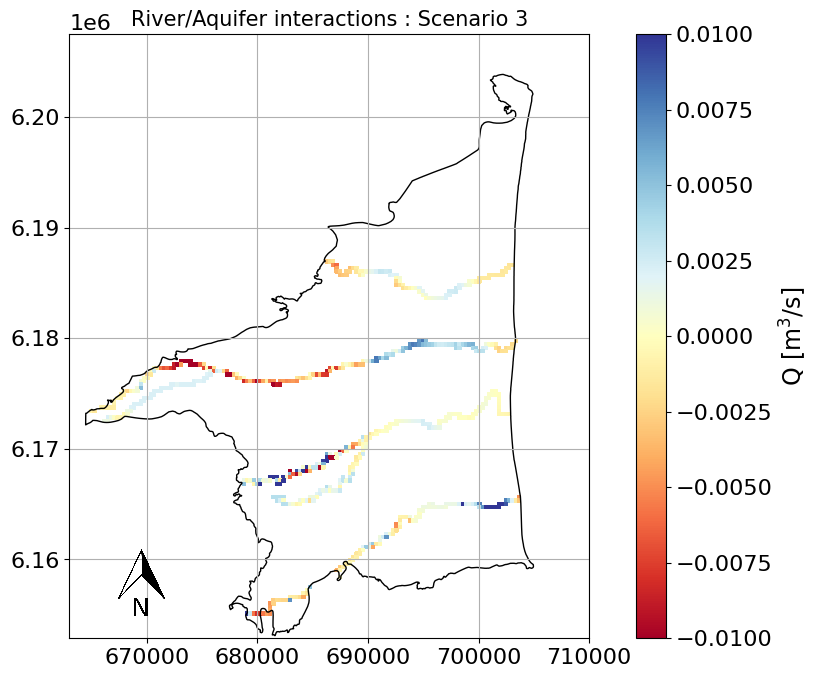

In [15]:
##plot rivers

arr = np.median(Qriv_s3,axis=0)
arr[arr==0]=np.nan
fig,ax = plt.subplots(figsize=(12,8),dpi=100)
ax.set_aspect("equal")

ml = fp.plot.PlotMapView(model=m,layer=1,ax=ax)
g = ml.plot_array(arr,cmap="RdYlBu",vmax=0.01,vmin=-0.01)
ax.set_title("River/Aquifer interactions : Scenario 3",fontsize=15)
c = plt.colorbar(g)
c.set_label(r"Q [m$^3$/s]",fontsize=17)
plt.grid()

fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",
                               facecolor="none",edgecolor="k",linewidth=1,ax=ax)

ax.set_xlim(6.63e5,7.1e5)
north(ax,zoom=0.02)

(662000.0, 710000.0)

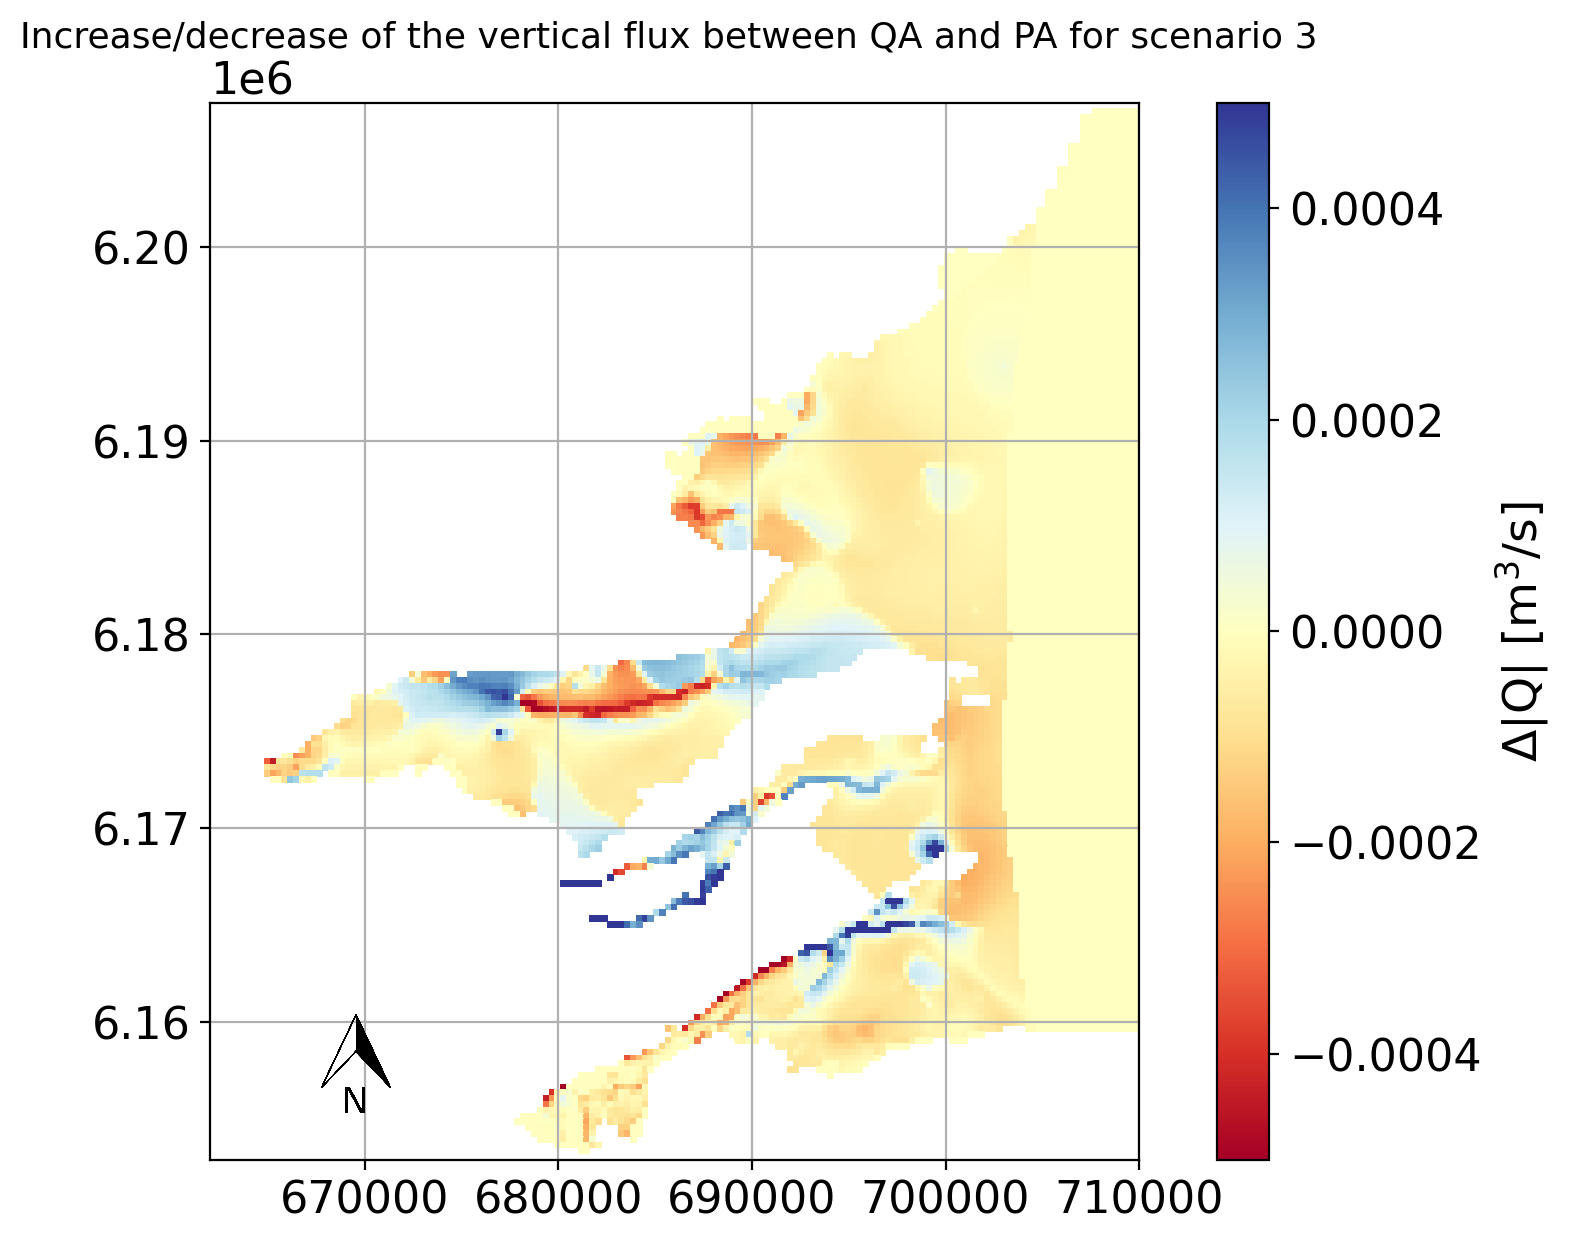

In [40]:
arr = np.median(np.abs(Q2PC_s3) - np.abs(Q2PC_ref),axis=0)

fig,ax = plt.subplots(figsize=(10,7),dpi=200)
ml = fp.plot.PlotMapView(model=m,layer=1,ax=ax)

ax.set_aspect("equal")
g = ml.plot_array(arr,cmap="RdYlBu",vmax=5e-4,vmin=-5e-4)
plt.title("Increase/decrease of the vertical flux between QA and PA for scenario 3 \n",fontsize=13)
c = plt.colorbar(g)
c.set_label(r"$\Delta$|Q| [m$^3$/s]",fontsize=17)
plt.grid()
north(ax,zoom=0.015)
ax.set_xlim(6.62e5,7.1e5)

(662000.0, 710000.0)

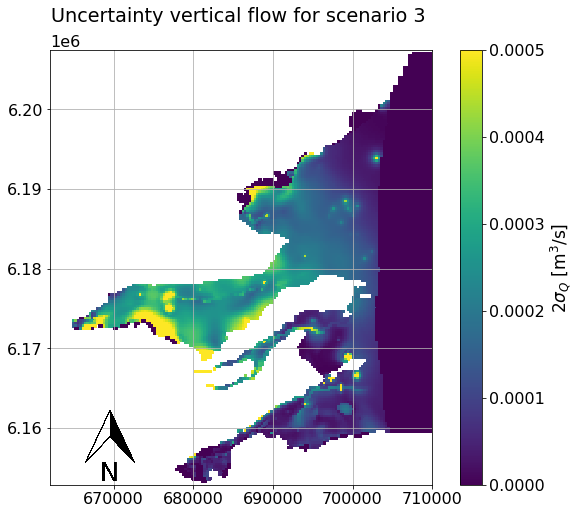

In [32]:
arr = np.std(Q2PC_s3,axis=0)

fig,ax = plt.subplots(figsize=(10,8))
ml = fp.plot.PlotMapView(model=m,layer=1,ax=ax)

ax.set_aspect("equal")
g = ml.plot_array(2*arr,cmap="viridis",vmax=5e-4)
plt.title("Uncertainty vertical flow for scenario 3 \n")
c = plt.colorbar(g)
c.set_label(r"$2\sigma_Q$ [m$^3$/s]",fontsize=17)
plt.grid()

north(ax,zoom=0.03)
ax.set_xlim(6.62e5,7.1e5)

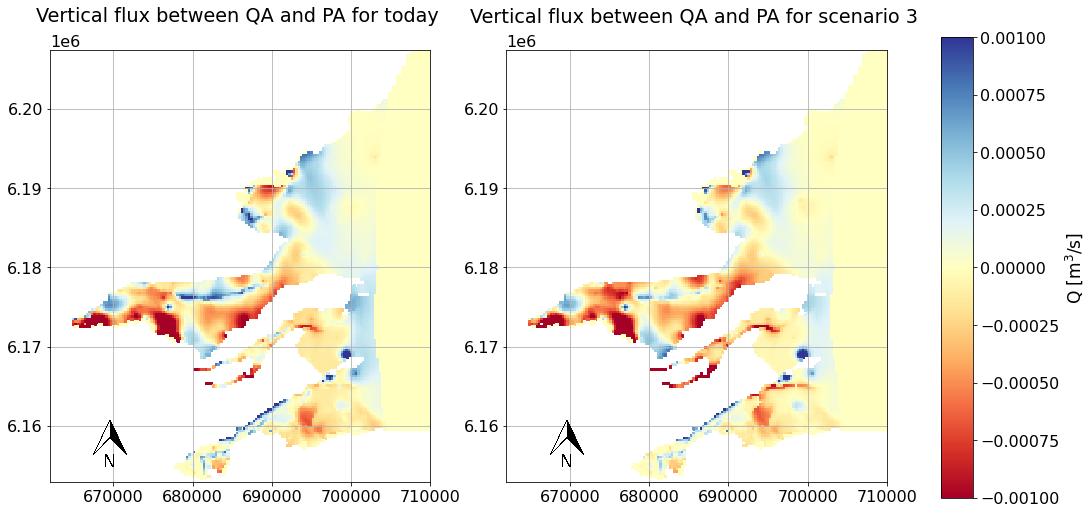

In [50]:
arr_s3 = np.median(Q2PC_s3,axis=0)
arr_ref = np.median(Q2PC_ref,axis=0)
arr = (arr_ref,arr_s3)
titles = ("today","scenario 3")

fig,ax = plt.subplots(1,2,figsize=(15,8))

for i in range(2):
    
    axi = ax[i]
    ml = fp.plot.PlotMapView(model=m,layer=1,ax=axi)
    arri = arr[i]
    axi.set_aspect("equal")
    ml.plot_bc("wel")
    g = ml.plot_array(arri,cmap="RdYlBu",vmax=1e-3,vmin=-1e-3)
    axi.set_title("Vertical flux between QA and PA for {} \n".format(titles[i]))
    axi.set_xlim(6.62e5,7.1e5)
    axi.grid()
    north(axi,zoom=0.02)

cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
c = plt.colorbar(g,cax=cbaxes)
c.set_label(r"Q [m$^3$/s]",fontsize=17)

Text(0.5, 0.98, 'Probability of observing net flux from QA to PA ')

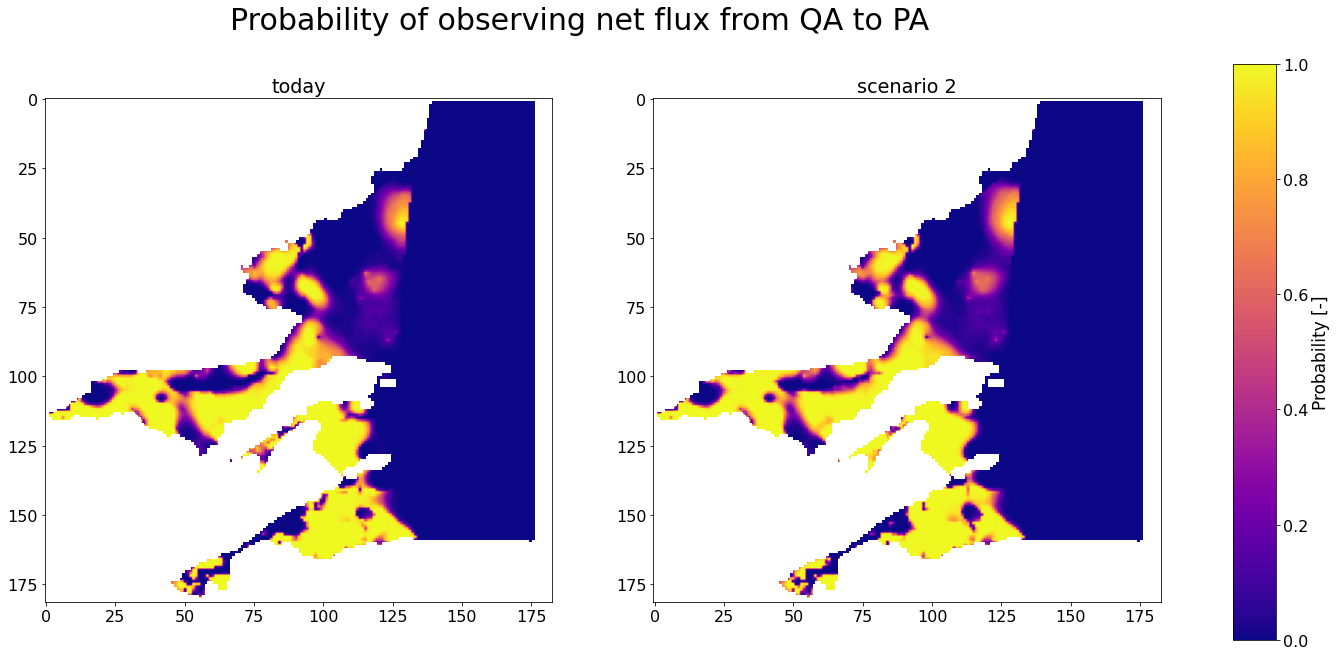

In [51]:
fig = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
P = np.zeros([nrow,ncol])
for i in range(150):
    t = Q2PC_ref[i] < 0
    P += t
P[idomain[1] != 1]=np.nan
plt.imshow(P/150,cmap="plasma")
plt.title("today")

plt.subplot(1,2,2)
P2 = np.zeros([nrow,ncol])
for i in range(150):
    t = Q2PC_s2[i] < 0
    P2 += t
P2[idomain[1] != 1]=np.nan
g=plt.imshow(P2/150,cmap="plasma")
plt.title("scenario 2")

cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
cb = plt.colorbar(g, cax = cbaxes)
cb.set_label("Probability [-]",fontsize=17)

fig.suptitle("Probability of observing net flux from QA to PA ",fontsize = 30)

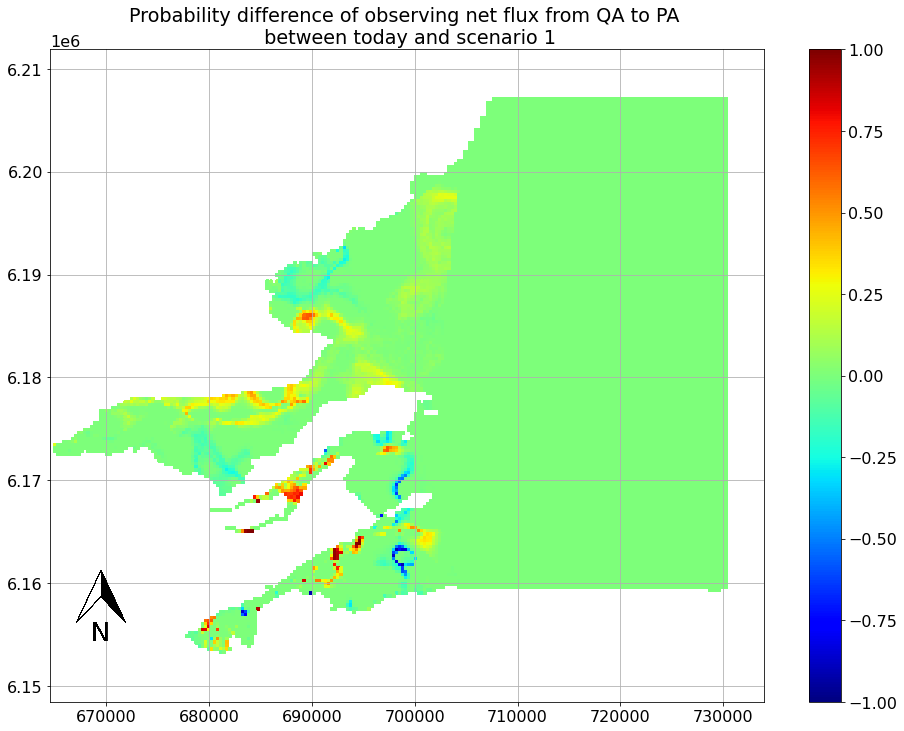

In [52]:
fig,ax = plt.subplots(figsize=(16,12))
ml = fp.plot.PlotMapView(model=m,layer=1,ax=ax)

plt.axis("equal")
g = ml.plot_array(P2/150-P/150,cmap="jet",vmax=1,vmin=-1)
plt.title("Probability difference of observing net flux from QA to PA \n between today and scenario 1")
plt.colorbar(g)
plt.grid()
north(ax,zoom=0.03)

In [53]:
# l = get_allbudgets(pred3_dr,150)
# pickle.dump(l, open( "BudgetS3.pkl", "wb" ))
# l = get_allbudgets(pred2_dr,150)
# pickle.dump(l, open( "BudgetS2.pkl", "wb" ))
# l = get_allbudgets(pred1_dr,150)
# pickle.dump(l, open( "BudgetS1.pkl", "wb" ))
# l = get_allbudgets(ref_dr,150)
# pickle.dump(l, open( "BudgetRef.pkl", "wb" ))

In [43]:
Bs1 = pickle.load(open("BudgetS1.pkl","rb"))
Bs2 = pickle.load(open("BudgetS2.pkl","rb"))
Bs3 = pickle.load(open("BudgetS3.pkl","rb"))
Bref = pickle.load(open("BudgetRef.pkl","rb"))

In [44]:
def plot_budg(l,ax):
    
    idx = l[0].index
    cols = l[0].columns
    Qmean = pd.DataFrame(np.mean(l,axis=0),index=idx,columns=cols)
    Qq10 = pd.DataFrame(np.quantile(l,0.05,axis=0),index=idx,columns=cols)
    Qq90 = pd.DataFrame(np.quantile(l,0.95,axis=0),index=idx,columns=cols)
    err = Qmean.T.groupby(level=[1]).sum().T - Qq10.T.groupby(level=[1]).sum().T
    
    #plot flux BCs
    Qmean[:14].T.groupby(level=[1]).sum().T.plot(kind="bar",yerr = err,ax=ax)

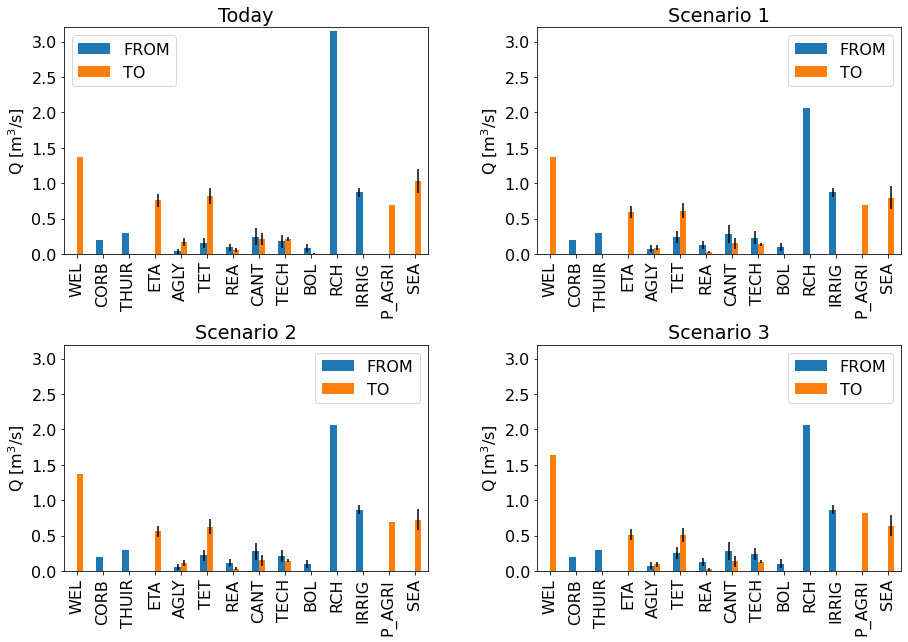

In [45]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=.4,wspace=0.3)
lst = [Bref,Bs1,Bs2,Bs3]
title = ["Today","Scenario 1","Scenario 2","Scenario 3"]
for i in range(1,5):
    ax = plt.subplot(2,2,i)
    plot_budg(lst[i-1],ax)
    ax.set_ylim(0,3.2)
    ax.set_title(title[i-1])
    ax.set_ylabel(r"Q [m$^3$/s]")

In [57]:
href = get_allheads(ref_dr)
hs1 = get_allheads(pred1_dr)
hs2 = get_allheads(pred2_dr)
hs3 = get_allheads(pred3_dr)

mu_ref,med_ref,s_ref,ecart_ref = process_heads(href)
mu_s1,med_s1,s_s1,ecart_s1 = process_heads(hs1)
mu_s2,med_s2,s_s2,ecart_s2 = process_heads(hs2)
mu_s3,med_s3,s_s3,ecart_s3 = process_heads(hs3)

In [85]:
def plot_head_with_ecart(head,ecart,layer=1,dpi=200):
    
    # initialize plot
    fig,axes = plt.subplots(2,1,figsize=(15,20),dpi=dpi)
    ml = fp.plot.PlotMapView(model=m,layer=layer)

    levels = [0,10,20,30,50,70,90,110,130,150]
    
    ax = axes[0]
    #plot heads
    hmesh = ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis",alpha=0.8,ax=ax)
    hmesh.set_clim(0,170)
    cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=levels,colors='black',ax=ax)
    plt.clabel(cont,fmt="%1i")
    
    ##cont des mesures piézométriques
    if layer == 3:
        pz="../../data/cartes_pz/Piézo_Pliocène_1990_V2.grd"
        leg = "Pliocene Aquifer 1990"
    elif layer == 1:
        pz = "../../data/cartes_pz/Pz_Quat_Avril2013_fromProf.grd"
        leg = "Quaternary Aquifer April 2013"
        
    rast = Raster.load(pz)
    Mes_pz = rast.resample_to_grid(grid.xcellcenters,grid.ycellcenters,1)

    Mes_pz[idomain[layer]==0]=np.nan
    cont_2=ml.contour_array(Mes_pz,levels=levels,colors='white',alpha=0.6,ax=ax)
    plt.clabel(cont_2,fmt="%1i")
    
    
    #legend
    proxy = [plt.Line2D((0,1),(0,0),color="black"),plt.Line2D((0,1),(0,0),color="lightgray")]
    ax.legend(proxy,["Simulated heads","{}".format(leg)])

    # plot bc
    ml.plot_bc("sea",color="b",alpha=0.5)
    for riv in m.riv:
        ml.plot_bc(riv.name[0],color="lightblue",alpha=0.5)
    ml.plot_bc("eta",color="b",alpha=0.5)
    ml.plot_bc("wel",alpha=0.5)
    ml.plot_bc("Corb",color="lightgreen",alpha=0.5)
    ml.plot_bc("thuir",color="darkblue",alpha=1)

    ax.tick_params(labelsize=15)
    north(ax,zoom=0.02)# plot north
    ax.grid(b=True)
    ax.set_aspect("equal")
    
    #colorbar
    clb = plt.colorbar(hmesh,ax=ax)
    clb.set_label("Head [m]",fontsize=15)
    clb.ax.tick_params(labelsize=15)
    
    
    ## ecarts ##
    ax  = axes[1]
    ec_plot = ml.plot_array(ecart[layer],cmap="viridis",alpha=0.7,ax=ax,vmax=5)
    #cont = ml.contour_array(ecart[layer],masked_values=[0,1e30],levels=[0,1,2,5],colors='black',ax=ax)
    #plt.clabel(cont,fmt="%1i") 
    
    # plot bc
    ml.plot_bc("sea",color="b",alpha=0.5)
    for riv in m.riv:
        ml.plot_bc(riv.name[0],color="lightblue",alpha=0.5)
    ml.plot_bc("eta",color="b",alpha=0.5)
    ml.plot_bc("wel",alpha=0.5)
    ml.plot_bc("Corb",color="lightgreen",alpha=0.5)
    ml.plot_bc("thuir",color="darkblue",alpha=1)
    
    north(ax,zoom=0.02) # plot north
    ax.set_aspect("equal")
    ax.grid(b=True)
    
    g = plt.colorbar(ec_plot,ax=ax)
    g.set_label(r"Uncertainty ($\pm$ 2$\sigma$) [m]",fontsize=15)
    g.ax.tick_params(labelsize=15)

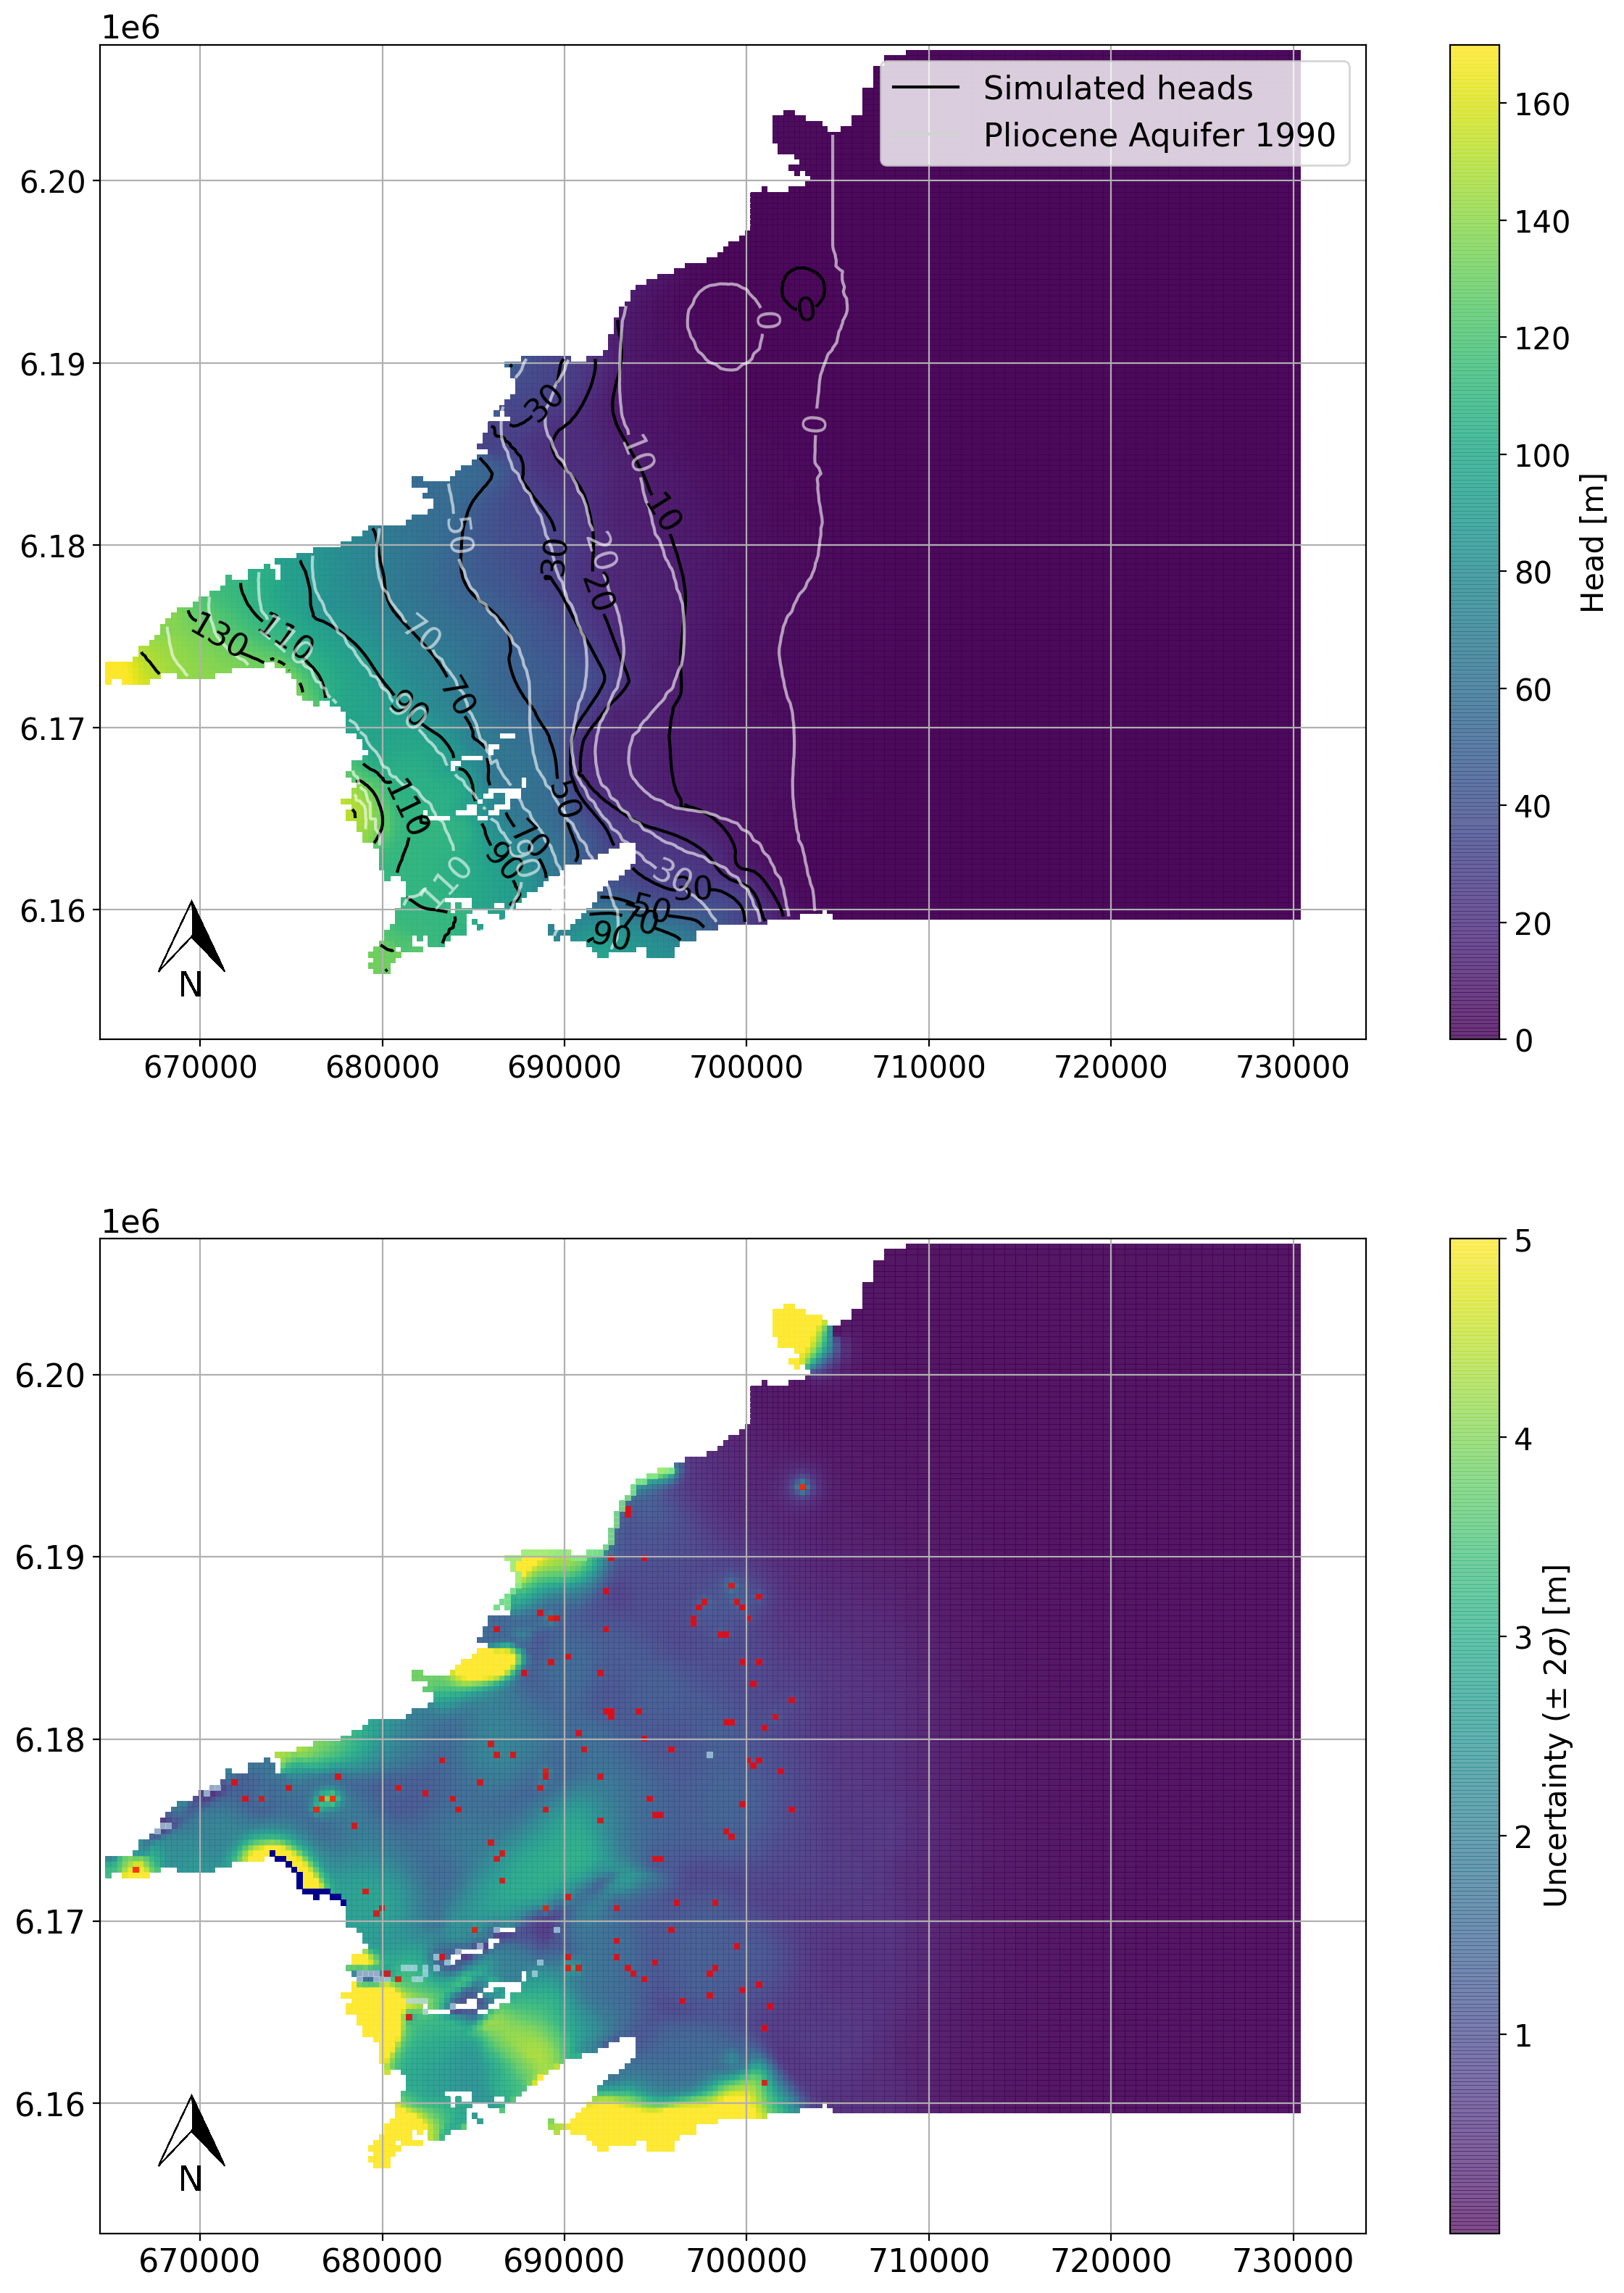

In [87]:
plot_head_with_ecart(med_ref,ecart_ref,layer=3)

In [149]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [150]:
def plot_heads(head_lst,layer=3):
    
    fig = plt.figure(figsize=(15,18))
    grids = plt.GridSpec(4, 4, wspace=0.05, hspace=0.25) # grid for plot
    a1 = fig.add_subplot(grids[0:2,0:2])
    a2 = fig.add_subplot(grids[0:2,2:4], yticklabels=[])
    a3 = fig.add_subplot(grids[2:4,1:3])

    ml = fp.plot.PlotMapView(model=m,layer=layer)
    titles = ["Scenario 1", "Scenario 2","Scenario 3"]
    ax = [a1,a2,a3]

    for i in range(3):
        head = head_lst[i]
        axi  = ax[i]
        axi.set_aspect("equal")
        hmesh = ml.plot_array(head[layer],masked_values=[0,1e30],cmap="Reds_r",ax=axi)
        hmesh.set_clim(0,10)
        quiver = ml.contour_array(head[layer],levels=np.linspace(0,10,6),colors='black',ax=axi)
        plt.clabel(quiver,fmt="%1i",fontsize=12)

        quiver2 = ml.contour_array(head[layer],levels=np.arange(0,1,1),colors='black',ax=axi)
        plt.clabel(quiver2,fmt="%1i",fontsize=12)

        fp.plot.plot_shapefile("../../data/shp/ligne_cote.shp",edgecolor="grey",facecolor="none",linewidth=3,ax=axi)
        ml.plot_bc("eta",color="green",alpha=0.5,ax=axi)

        # figures format and +
        axi.grid()
        north(axi,zoom=0.02)
        axi.set_xlim(664525,664525+4.7e4)
        axi.set_title("{}".format(titles[i]))

    #colorbar
    cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
    cb = plt.colorbar(hmesh, cax = cbaxes)
    cb.set_label("Head variation [m]",fontsize=17)

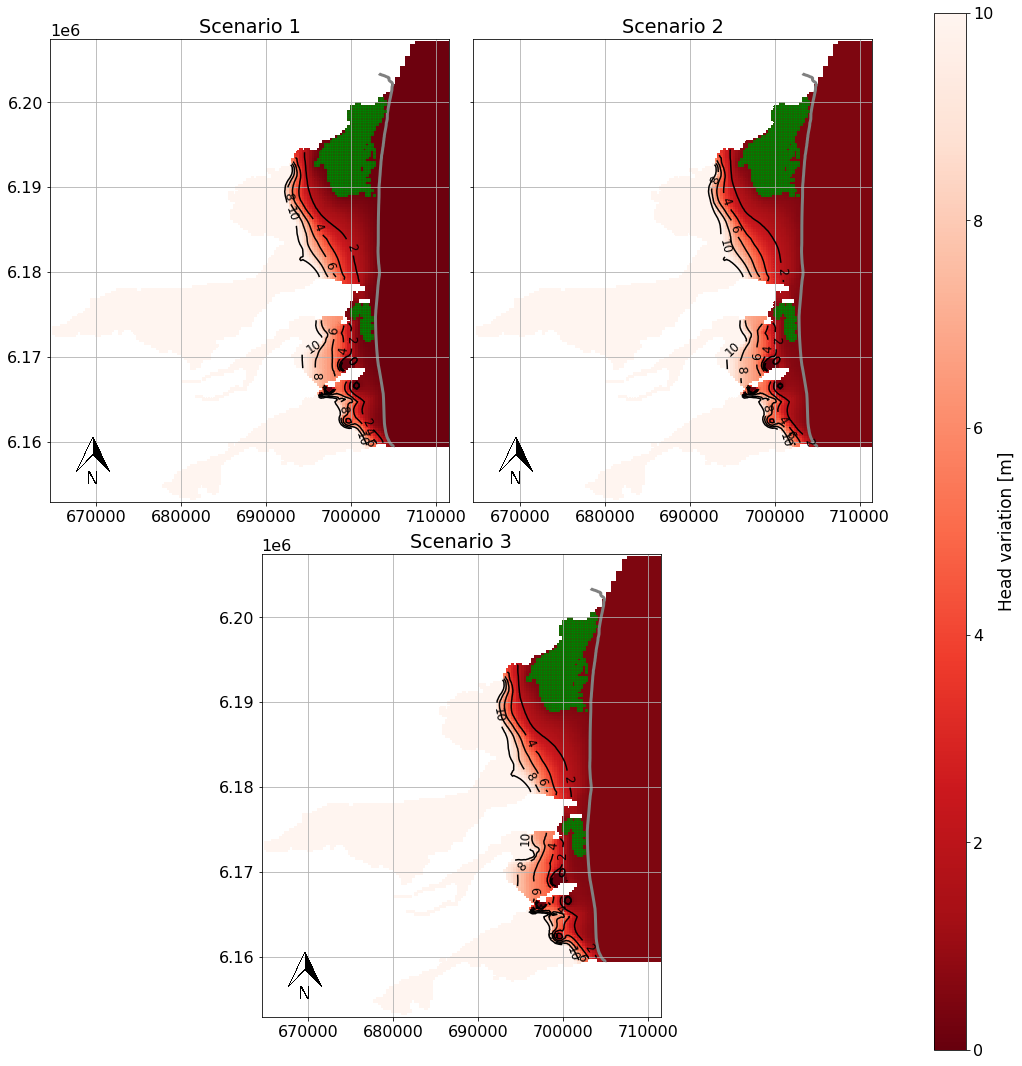

In [151]:
head_lst = [med_s1,med_s2,med_s3]
plot_heads(head_lst,layer=1)

In [152]:
def plot_heads_diff(head_lst,head_ref,layer=3):
    
    fig = plt.figure(figsize=(15,18))
    grids = plt.GridSpec(4, 4, wspace=0.05, hspace=0.25) # grid for plot
    a1 = fig.add_subplot(grids[0:2,0:2])
    a2 = fig.add_subplot(grids[0:2,2:4], yticklabels=[])
    a3 = fig.add_subplot(grids[2:4,1:3])

    ml = fp.plot.PlotMapView(model=m,layer=layer)
    titles = ["Scenario 1", "Scenario 2","Scenario 3"]
    ax = [a1,a2,a3]

    for i in range(3):
        head = head_lst[i]
        axi  = ax[i]
        axi.set_aspect("equal")
        hmesh = ml.plot_array(head[layer]-head_ref[layer],masked_values=[0,1e30],cmap="Reds_r",ax=axi)
        hmesh.set_clim(-5,0)
        quiver = ml.contour_array(head[layer]-head_ref[layer],levels=[-15,-10,-5,-3,-1],colors='black',ax=axi)
        plt.clabel(quiver,fmt="%1i",fontsize=12)

        quiver2 = ml.contour_array(head[layer]-head_ref[layer],levels=np.arange(0,1,1),colors='black',ax=axi)
        plt.clabel(quiver2,fmt="%1i",fontsize=12)

        fp.plot.plot_shapefile("../../data/shp/ligne_cote.shp",edgecolor="grey",facecolor="none",linewidth=3,ax=axi)
        ml.plot_bc("eta",color="green",alpha=0.5,ax=axi)

        # figures format and +
        axi.grid()
        north(axi,zoom=0.02)
        axi.set_xlim(664525,664525+4.7e4)
        axi.set_title("{}".format(titles[i]))

    #colorbar
    cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
    cb = plt.colorbar(hmesh, cax = cbaxes)
    cb.set_label("Head variation [m]",fontsize=17)

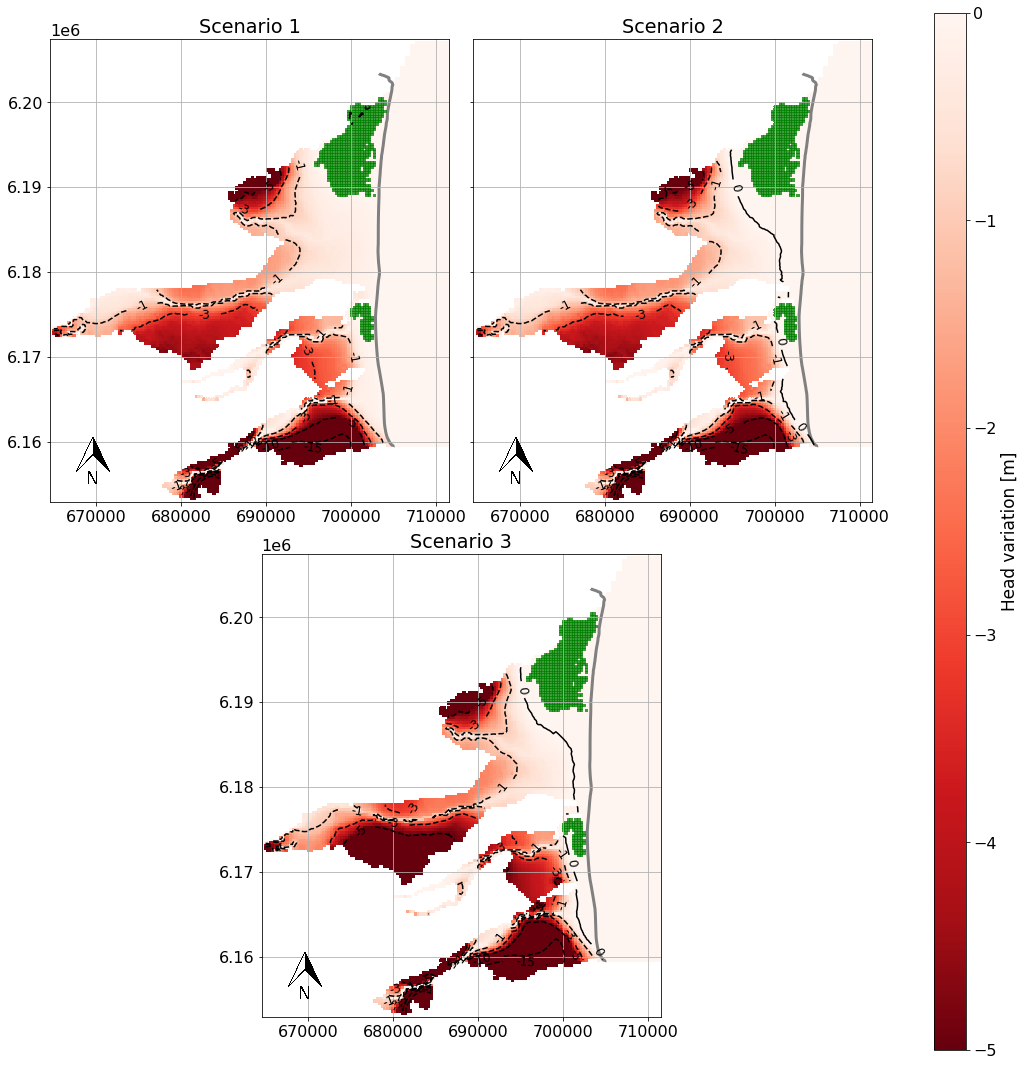

In [154]:
head_lst = [med_s1,med_s2,med_s3]
plot_heads_diff(head_lst,med_ref,layer=1)

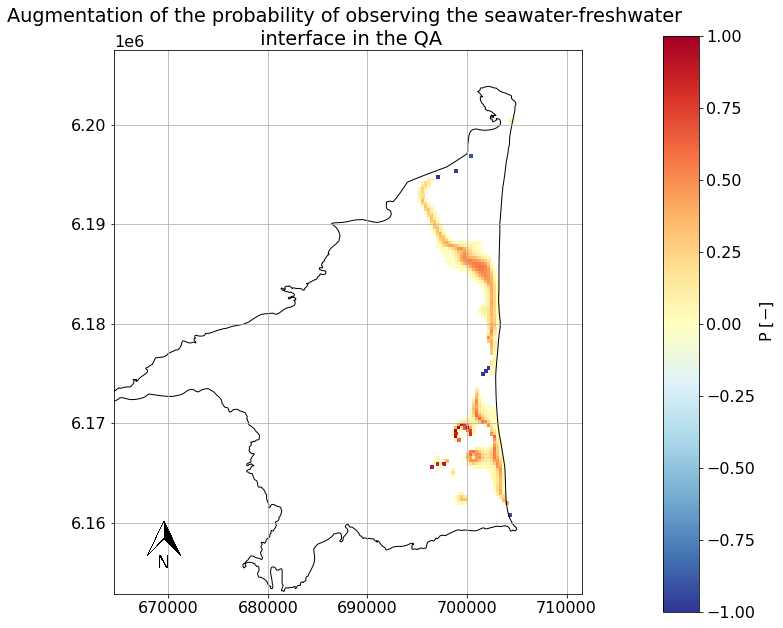

In [207]:
layer = 1

fig,ax = plt.subplots(figsize=(10,10))
ml = fp.plot.PlotMapView(model=m,layer=layer,ax=ax)
P = np.zeros([nrow,ncol])
for h in href:
    arr = botm[1]+(40*(h[1].copy()-0)+0)
    P += arr < 0

P /= 150

P2 = np.zeros([nrow,ncol])
for h in hs3:
    arr = botm[1]+(40*(h[1].copy()-0.35)+0.35)
    P2 += arr < 0

P2 /= 150

arr = P2 - P
arr[arr==0]=np.nan
hmesh = ml.plot_array(arr,cmap="RdYlBu_r",ax=ax)
hmesh.set_clim(-1,1)
plt.grid()
fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",
                               facecolor="none",edgecolor="k",linewidth=1,ax=ax)

ax.set_xlim(664525,664525+4.7e4)
ax.set_title("Augmentation of the probability of observing the seawater-freshwater \n interface in the QA")
#colorbar
cbaxes = fig.add_axes([0.95, 0.1, 0.05, 0.8]) 
cb = plt.colorbar(hmesh, cax = cbaxes)
cb.set_label(r" P $[-]$")
north(ax,0.02)

ax.set_aspect("equal")

In [230]:
def plot_biseau(head_lst):

    fig = plt.figure(figsize=(15,18))
    layer = 1

    grids = plt.GridSpec(4, 4, wspace=0.05, hspace=0.25) # grid for plot
    a1 = fig.add_subplot(grids[0:2,0:2])
    a2 = fig.add_subplot(grids[0:2,2:4], yticklabels=[])
    a3 = fig.add_subplot(grids[2:4,0:2])
    a4 = fig.add_subplot(grids[2:4,2:4], yticklabels=[])

    ml = fp.plot.PlotMapView(model=m,layer=layer)
    titles = ["Today","Scenario 1", "Scenario 2","Scenario 3"]
    ax = [a1,a2,a3,a4]

    for i in range(4):
        head = head_lst[i]

        if (titles[i]== "Today") | (titles[i] == "Scenario 1"):
            arr = botm[layer]+(40*(head[layer]))
        else:
            arr = botm[layer]+(40*(head[layer].copy()-0.35)+.35)
        arr[np.abs(arr) > 100] = None

        axi  = ax[i]
        axi.set_aspect("equal")
        hmesh = ml.plot_array(-arr,cmap="RdYlBu_r",ax=axi)
        hmesh.set_clim(-50,50)
        cont = ml.contour_array(arr,levels=[0],colors="k",ax=axi)
        plt.clabel(cont,fmt="%1i",fontsize=12)

        ##bc
        ml.plot_bc("eta",color="green",alpha=0.5,ax=axi)
        ml.plot_bc("wel",ax=axi)

        # figures format and +
        axi.grid()
        north(axi,zoom=0.02)
        axi.set_xlim(664525,664525+4.7e4)
        axi.set_title("{}".format(titles[i]))
        fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",
                               facecolor="none",edgecolor="k",linewidth=1,ax=axi)
    #colorbar
    cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
    cb = plt.colorbar(hmesh, cax = cbaxes)
    cb.set_label("Interface aquifer/saltwater height with respect to the Quat botom [m]",fontsize=17)

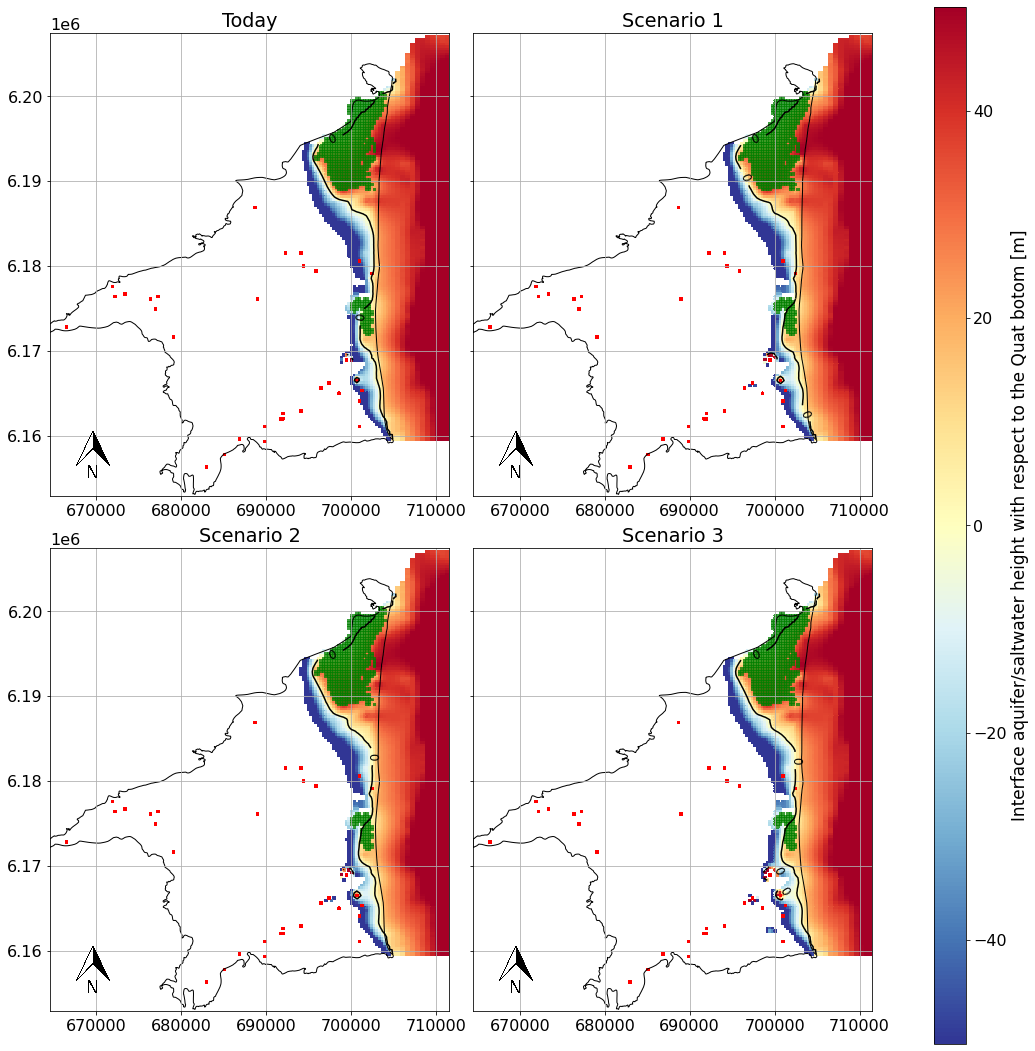

In [231]:
h_lst = [med_ref,med_s1,med_s2,med_s3]
plot_biseau(h_lst)

In [348]:
ref_biseau = botm[1]+(40*(med_ref[1]))
ref_biseau[ref_biseau>100]=np.nan

biseau = botm[1]+(40*(med_s3[1].copy()-0.35)+.35)
biseau[biseau>100]=np.nan

var_biseau = (biseau - ref_biseau)
var_biseau[ref_biseau>0] = np.nan

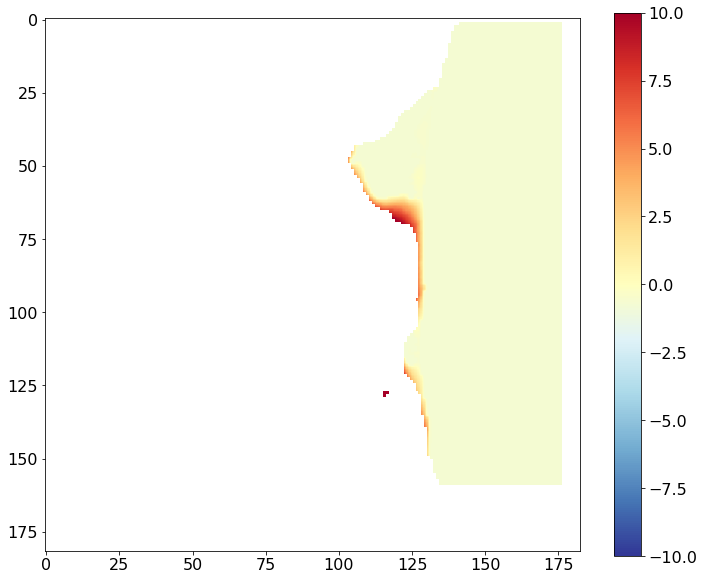

In [349]:
plt.figure(figsize=(12,10))
plt.imshow(-var_biseau,vmax=10,vmin=-10,cmap="RdYlBu_r")
plt.colorbar()